In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1


#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np
from math import erf, sqrt

from scipy.special import erfcinv
from scipy.stats import chi2, gamma
from scipy.special import erfcinv, erfinv, erf, erfc
from scipy.linalg import sqrtm
from scipy.interpolate import interp1d

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import git
import os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print('Path to git repo: {}'.format(path_global))

chi2_val = chi2.ppf(0.6827, df=2)

d = 2
L = 3  # Number of vectors
n_samples = int(1e6)

Path to git repo: /home/matias/Documents/PhD/code


# PTE to $N_{\sigma}$

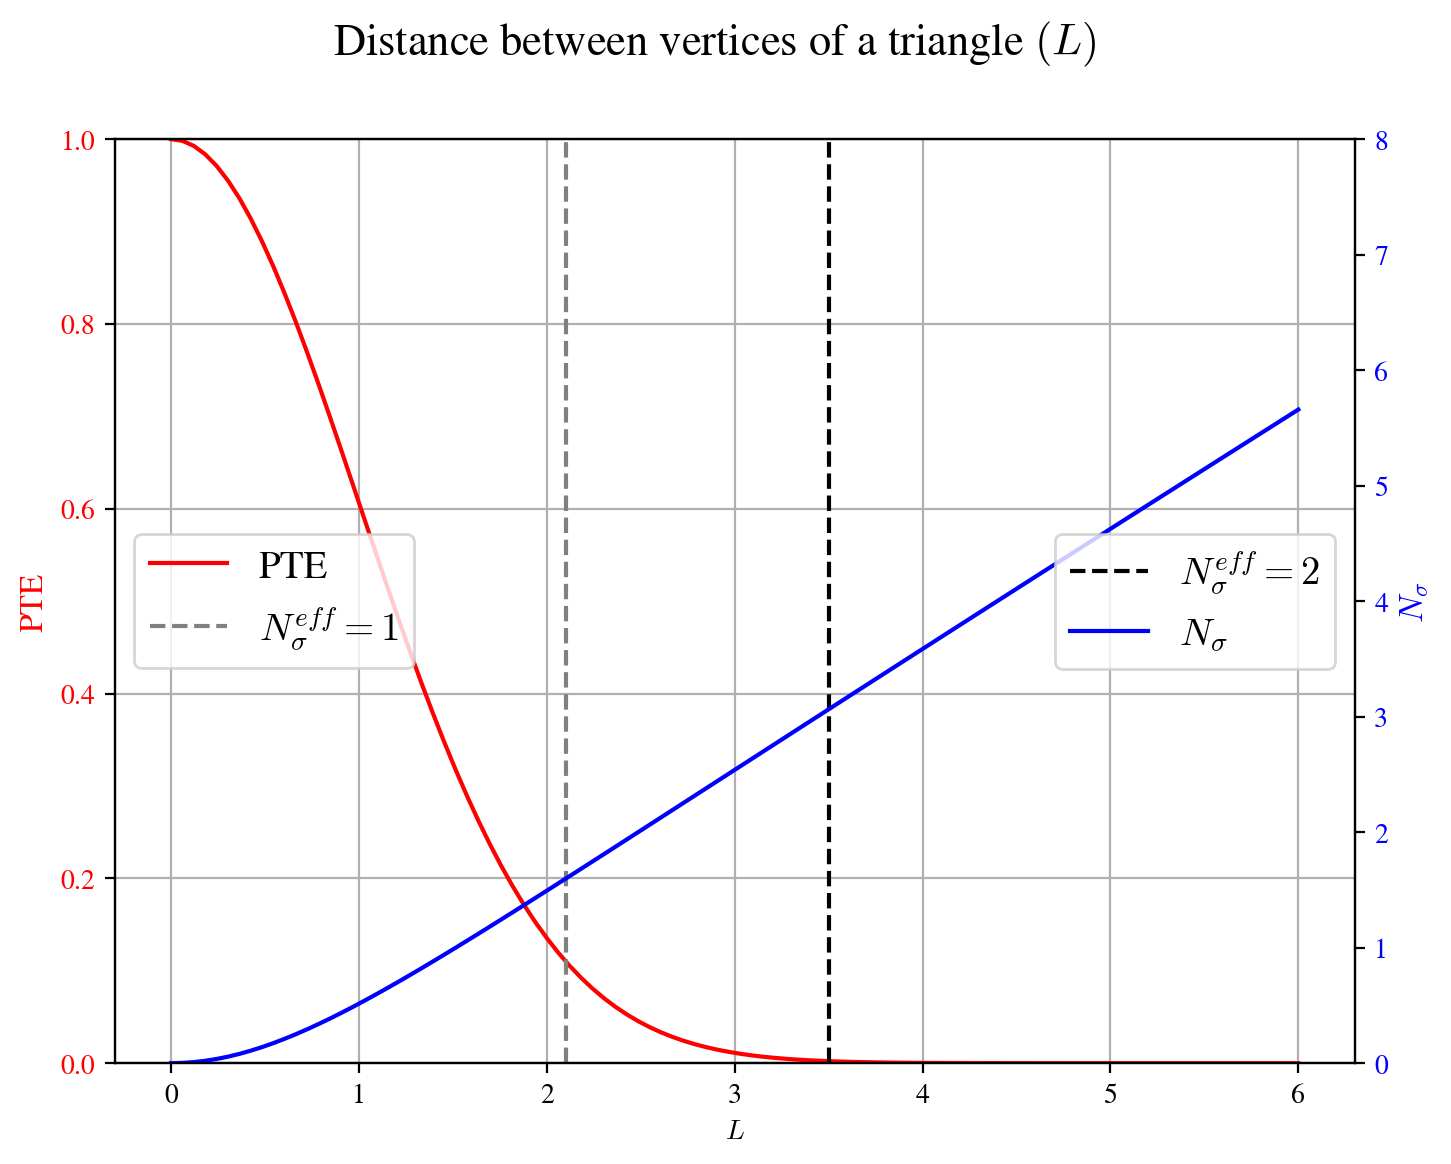

In [2]:
#Sharp triangle
factor = np.linspace(0, 6, 100)
PTE_arr = np.zeros(len(factor))
n_sigma_arr = np.zeros(len(factor))

for i in range(len(factor)):
    mean_A = factor[i] * np.array([-1/2., 0.]) 
    mean_B = factor[i] * np.array([1/2, 0.])

    cov_A = np.eye(d) / 2
    cov_B = cov_A.copy()
    cov_C = cov_A.copy()

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    
    # Example usage:
    beta_L = np.linalg.norm(r_1)**2

    PTE_arr[i] = chi2(d).sf(beta_L)
    n_sigma_arr[i] = np.sqrt(2)*erfcinv(PTE_arr[i])

fig, axes = plt.subplots(1,1, figsize=(8, 6))
fig.suptitle(r'Distance between vertices of a triangle $(L)$'.format(factor[i]), fontsize=16)

ax1 = axes
ax2 = ax1.twinx()

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 8)


ax1.plot(factor, PTE_arr, label='PTE', color='red')
ax1.set_xlabel(r'$L$')
ax1.set_ylabel('PTE', color='red', fontsize=12)
ax1.tick_params(axis='y', labelcolor='red')
ax1.vlines(x=2.1, ymin=0, ymax=8, color='gray', linestyle='--',label='$N_\sigma^{eff} = 1$')
ax2.vlines(x=3.5, ymin=0, ymax=8, color='black', linestyle='--',label='$N_\sigma^{eff} = 2$')

ax2.plot(factor, n_sigma_arr, label='$N_\sigma$', color='blue')
ax2.set_ylabel('$N_\sigma$', color='blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='blue')

ax1.legend(loc='center left', fontsize=14)
ax2.legend(loc='center right', fontsize=14)

ax1.grid()

fig.savefig(os.path.join(path_global, 'multidimensional_qdm_tension_vectors_sweap_cov.png'), dpi=300, bbox_inches='tight')
plt.show()

Que es $N_{\sigma}^{eff}$? Hagamos algunos graficos

In [3]:
def L_iso_from_n(d: int, n: float, sigma2: float = 0.5, gauss_scale: str = '1sigma') -> float:
    """
    Distancia euclídea L entre las medias de dos Gaussianas D-dimensionales
    idénticas e isotrópicas (Sigma = sigma2 * I), tal que sus contornos 
    que en 1D corresponden a ±nσ se 'toquen'.

    Parámetros
    ----------
    d : int
        Dimensión (D).
    n : float
        'Número de sigmas' 1D (es decir, p = erf(n / sqrt(2))).
    sigma2 : float, opcional
        Varianza isotrópica por eje (default 0.5).

    Devuelve
    --------
    L : float
        Distancia euclídea entre medias.
    """


    if gauss_scale == '1sigma':
        # Probabilidad 1D asociada a ±nσ
        p = erf(n / sqrt(2.0)) #is the same, less general
        #p = chi2.cdf(n**2, df=1)  # Cumulative distribution function for chi2Q
    elif gauss_scale == '2sigma':
        p = chi2.cdf(n**2, df=2)  # Cumulative distribution function for chi2

    # Cuantil chi-cuadrado con d grados de libertad
    m2 = chi2.ppf(p, df=d)              # m^2 = χ²_{d,p}
    m  = sqrt(m2)
    # En isotrópico: L = 2 * σ * m, con σ = sqrt(sigma2)
    return 2.0 * sqrt(sigma2) * m

print('--- Using 1sigma scale ---')
for n in [1, 2, 3, 4, 5]:
    print(n, L_iso_from_n(d=2, n=n))   # d=2, sigma^2=0.5

print('--- Using 2sigma scale ---')
for n in [1, 2, 3, 4, 5]:
    print(n, L_iso_from_n(d=2, n=n, gauss_scale='2sigma'))   # d=2, sigma^2=0.5

--- Using 1sigma scale ---
1 2.142778070122352
2 3.515700301858557
3 4.863981513513553
4 6.21834521588094
5 7.5820448992254725
--- Using 2sigma scale ---
1 1.4142135623730951
2 2.8284271247461903
3 4.242640687119287
4 5.656854249492375
5 7.071067811867373


In [4]:
erf(1 / np.sqrt(2.0))

np.float64(0.6826894921370859)

Factor: 0.0, PTE: 1, N_sigma: -0


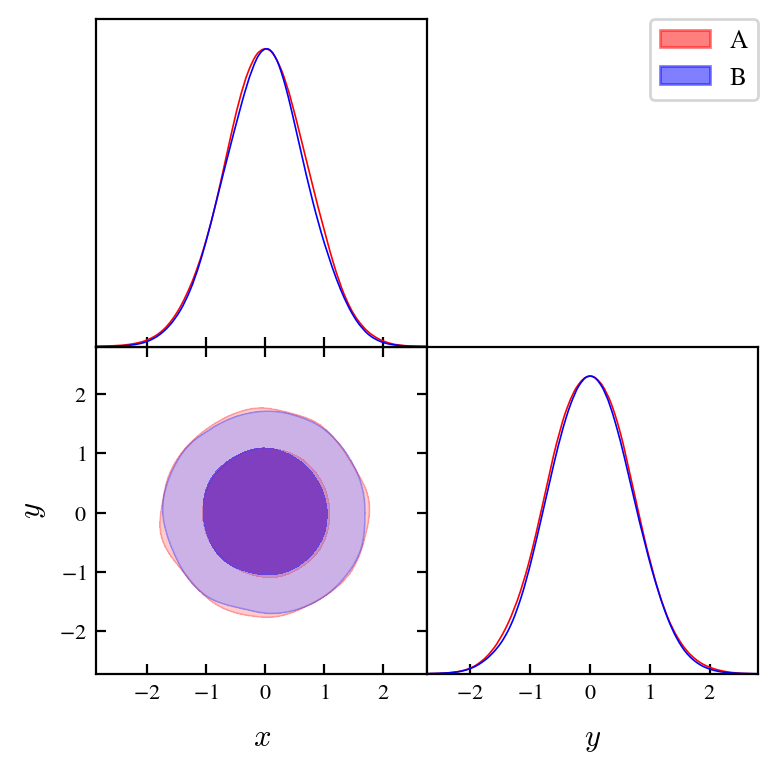

Factor: 2.142778070122352, PTE: 0.101, N_sigma: 1.64


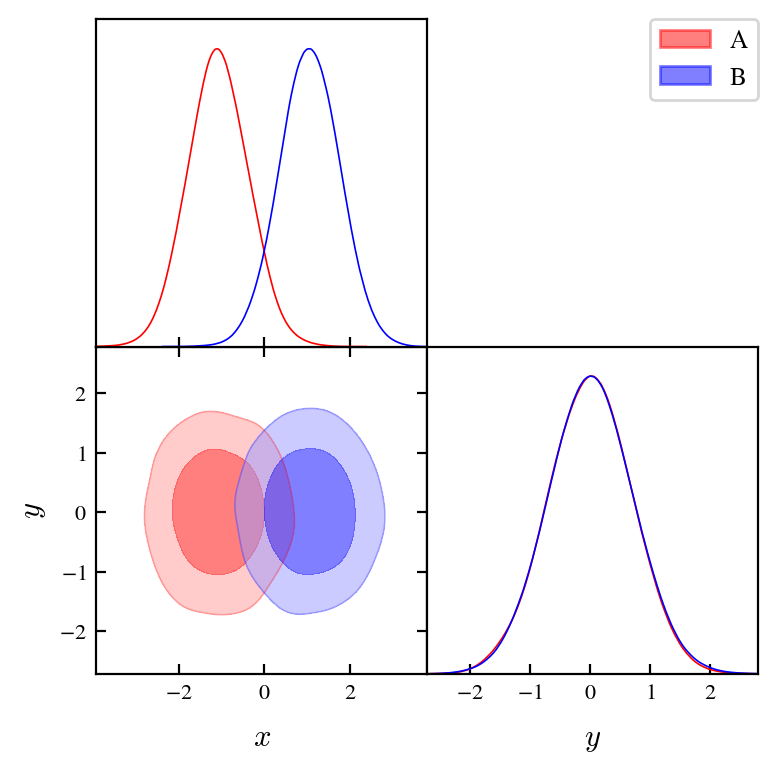

Factor: 3.515700301858557, PTE: 0.00207, N_sigma: 3.08


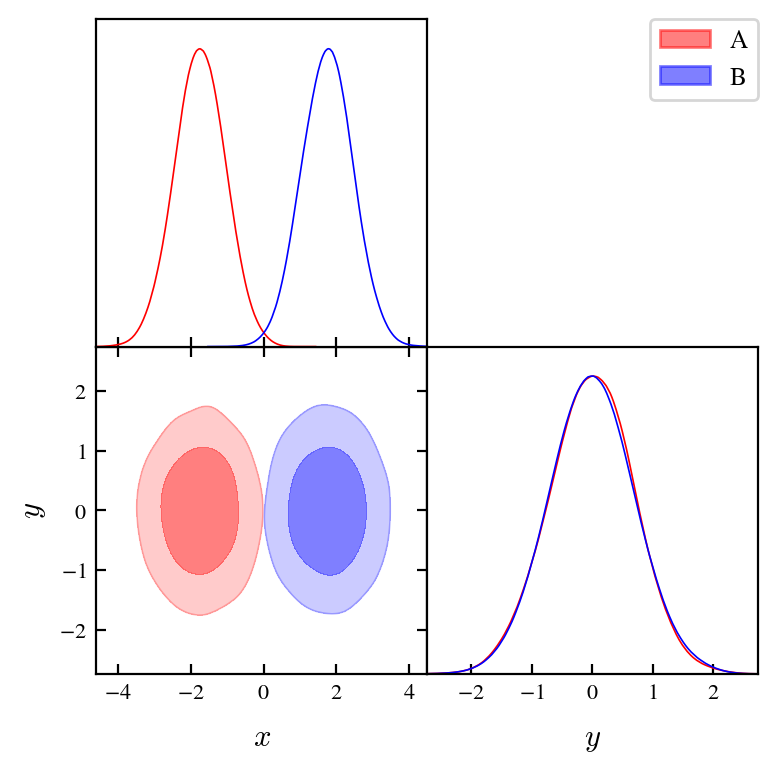

Factor: 4.863981513513553, PTE: 7.29e-06, N_sigma: 4.49


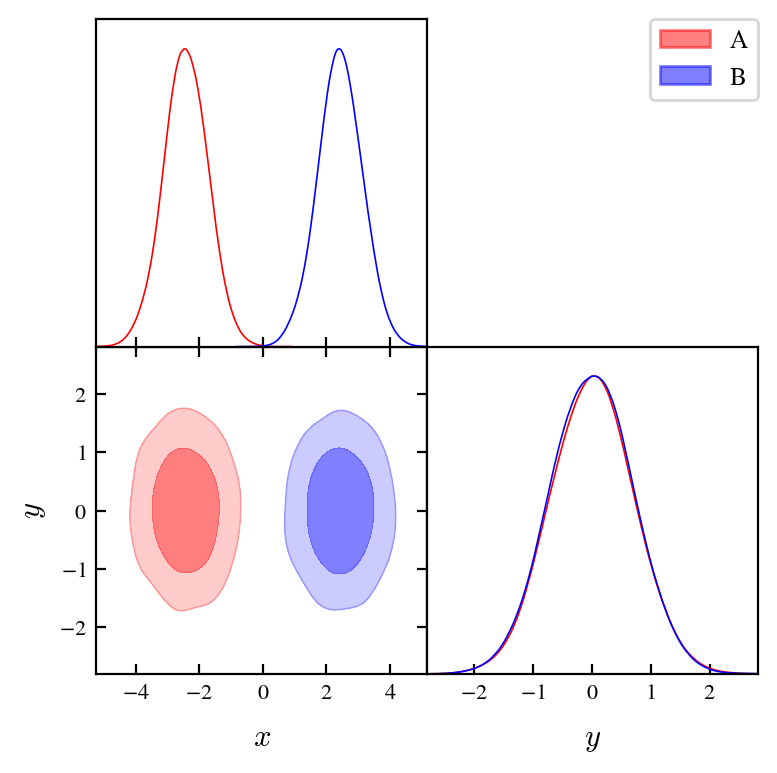

Factor: 6.21834521588094, PTE: 4.01e-09, N_sigma: 5.88


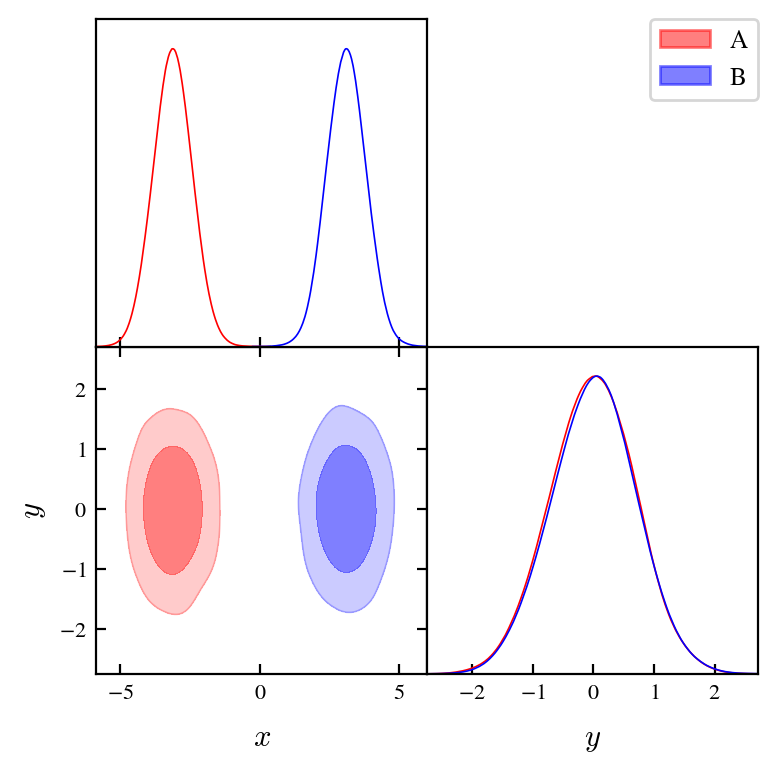

Factor: 7.5820448992254725, PTE: 3.29e-13, N_sigma: 7.28


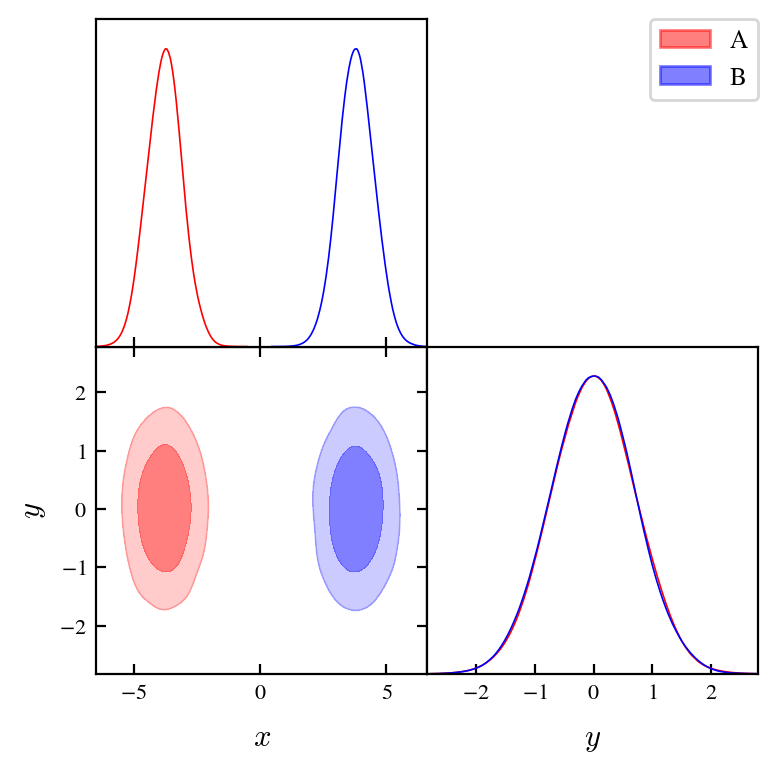

In [5]:
#Sharp triangle

factor = [0., L_iso_from_n(d=2, n=1),
          L_iso_from_n(d=2, n=2), L_iso_from_n(d=2, n=3),
          L_iso_from_n(d=2, n=4), L_iso_from_n(d=2, n=5)]


for i in range(len(factor)):
    mean_A = factor[i] * np.array([-1/2., 0.])
    mean_B = factor[i] * np.array([1/2, 0.])

    cov_A = np.eye(d) / 2
    cov_B = cov_A.copy()
    cov_C = cov_A.copy()

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))

    # Example usage:
    beta_L = np.linalg.norm(r_1)**2

    PTE = chi2(d).sf(beta_L)
    n_sigma = np.sqrt(2)*erfcinv(PTE)

    print(f"Factor: {factor[i]}, PTE: {PTE:.3g}, N_sigma: {n_sigma:.3g}")


    names = ['x', 'y']
    labels = ['x', 'y']

    lim_x = np.array([-10, 10])
    lim_y = np.array([-10, 10])

    samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
    samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)

    chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
    chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')

    colors = ['red', 'blue', 'green']

    g = plots.get_subplot_plotter()
    g.triangle_plot([chain_A, chain_B],\
                    filled=True, contour_args={'alpha':0.5},\
                    contour_colors=colors,
                    legend_labels=['A', 'B'])
    #g.add_param_markers({'x':[mean_A[0], mean_B[0], mean_C[0]],
    #                    'y':[mean_A[1], mean_B[1], mean_C[1]],
    #                    },)

    #g.export(os.path.join(path_global, 'multidimensional_qdm_tension_vectors_triangle_L_{:.3g}.png'.format(factor[i])))
    plt.show()

Factor: 0.0, PTE: 1, N_sigma: -0


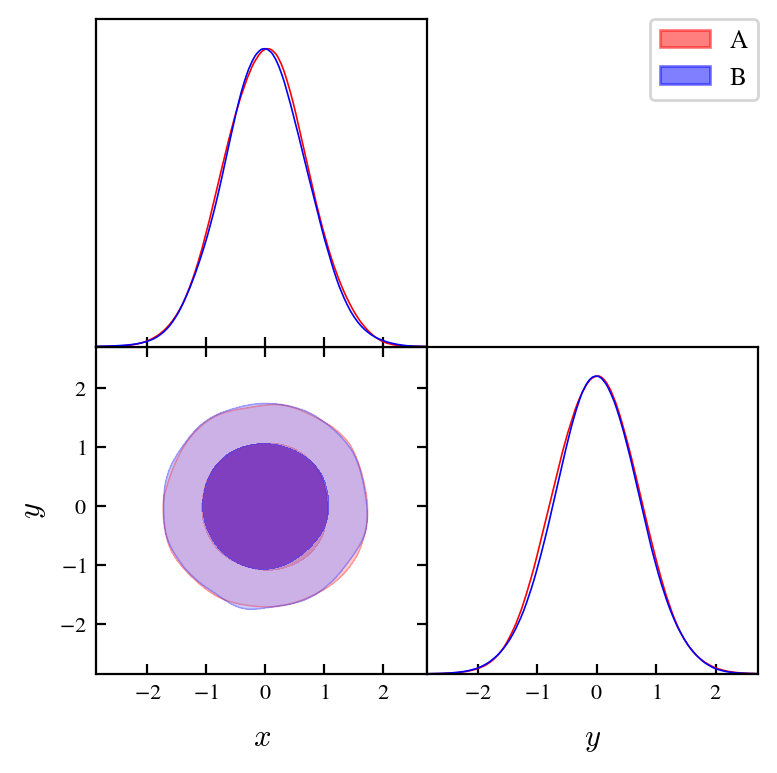

Factor: 1.4142135623730951, PTE: 0.368, N_sigma: 0.9


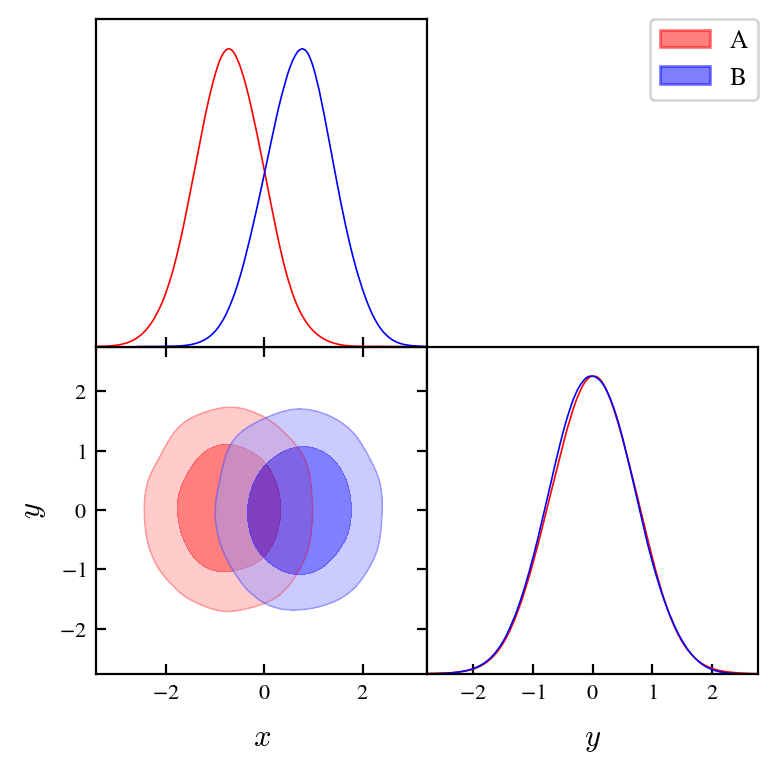

Factor: 2.8284271247461903, PTE: 0.0183, N_sigma: 2.36


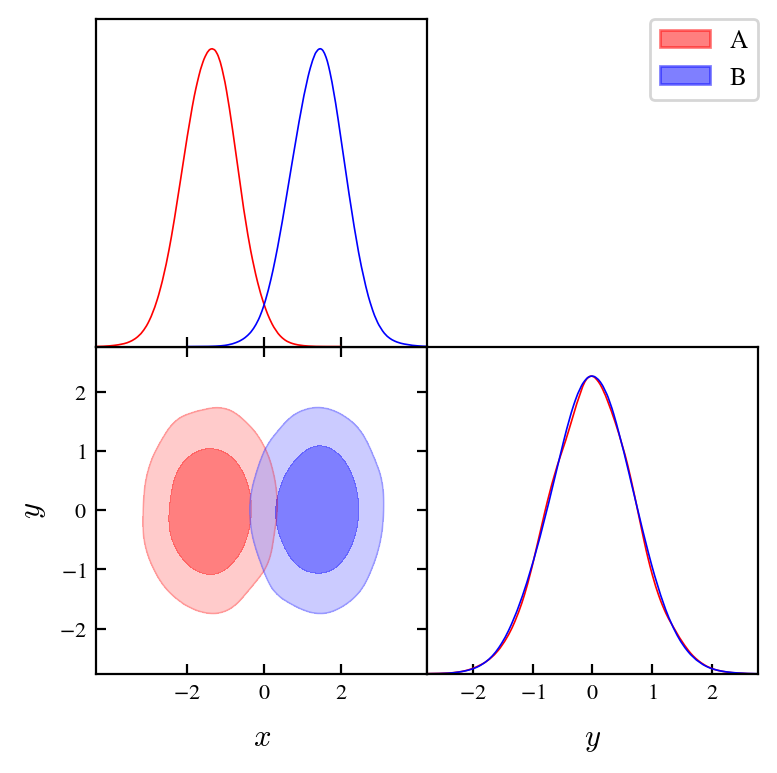

Factor: 4.242640687119287, PTE: 0.000123, N_sigma: 3.84


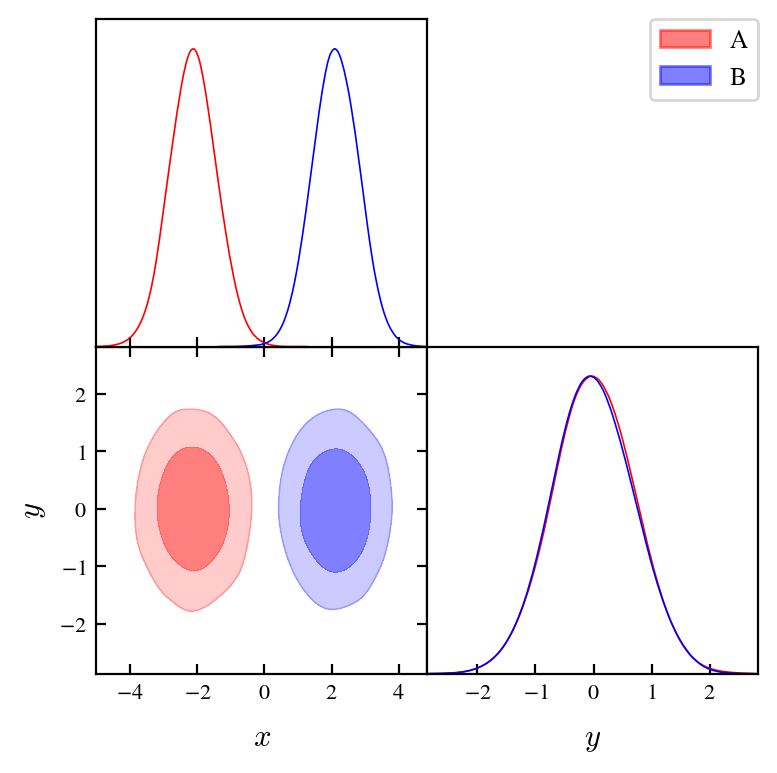

Factor: 5.656854249492375, PTE: 1.13e-07, N_sigma: 5.31


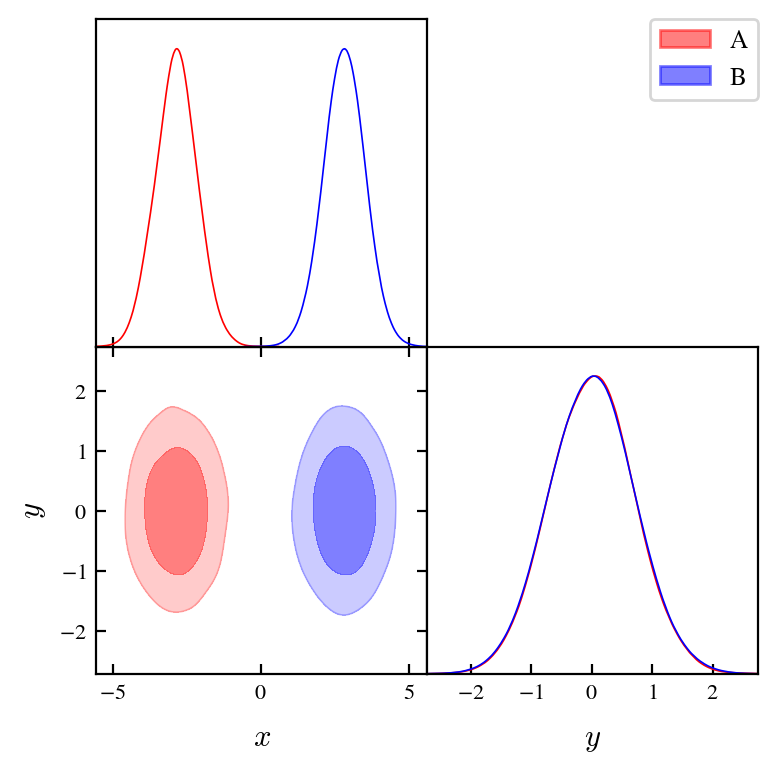

Factor: 7.071067811867373, PTE: 1.39e-11, N_sigma: 6.76


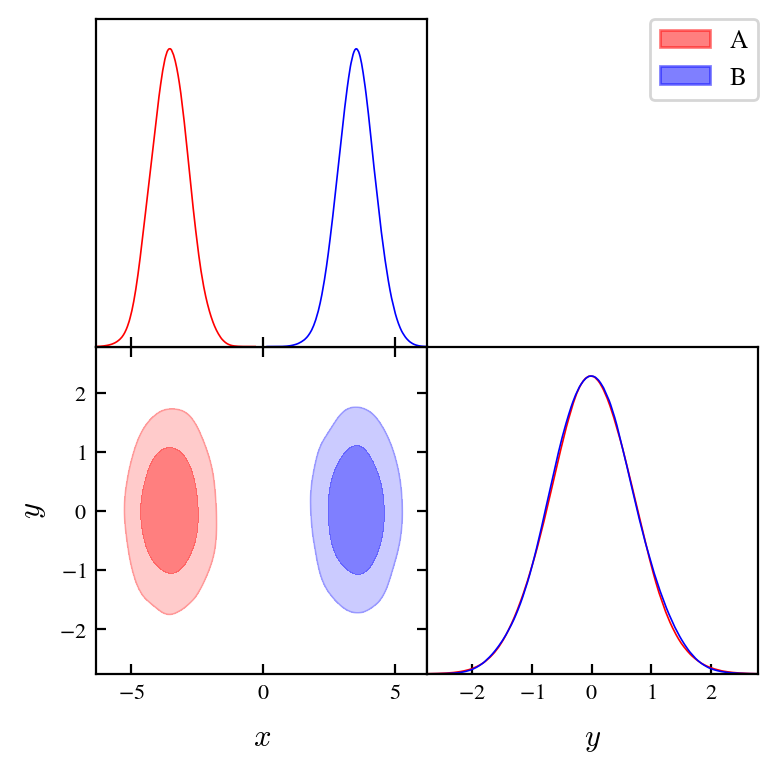

In [6]:
#Sharp triangle

factor = [0., 
          L_iso_from_n(d=2, n=1,gauss_scale='2sigma'),
          L_iso_from_n(d=2, n=2,gauss_scale='2sigma'),
          L_iso_from_n(d=2, n=3,gauss_scale='2sigma'),
          L_iso_from_n(d=2, n=4,gauss_scale='2sigma'),
          L_iso_from_n(d=2, n=5,gauss_scale='2sigma')]


for i in range(len(factor)):
    mean_A = factor[i] * np.array([-1/2., 0.])
    mean_B = factor[i] * np.array([1/2, 0.])

    cov_A = np.eye(d) / 2
    cov_B = cov_A.copy()
    cov_C = cov_A.copy()

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))

    # Example usage:
    beta_L = np.linalg.norm(r_1)**2

    PTE = chi2(d).sf(beta_L)
    n_sigma = np.sqrt(2)*erfcinv(PTE)

    print(f"Factor: {factor[i]}, PTE: {PTE:.3g}, N_sigma: {n_sigma:.3g}")


    names = ['x', 'y']
    labels = ['x', 'y']

    lim_x = np.array([-10, 10])
    lim_y = np.array([-10, 10])

    samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
    samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)

    chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
    chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')

    colors = ['red', 'blue', 'green']

    g = plots.get_subplot_plotter()
    g.triangle_plot([chain_A, chain_B],\
                    filled=True, contour_args={'alpha':0.5},\
                    contour_colors=colors,
                    legend_labels=['A', 'B'])
    #g.add_param_markers({'x':[mean_A[0], mean_B[0], mean_C[0]],
    #                    'y':[mean_A[1], mean_B[1], mean_C[1]],
    #                    },)

    #g.export(os.path.join(path_global, 'multidimensional_qdm_tension_vectors_triangle_L_{:.3g}.png'.format(factor[i])))
    plt.show()

# Same L, $N_\sigma^{N_d = 2}, N_\sigma^{N_d = 3}, N_\sigma^{eff}$

In [7]:
factor = np.linspace(0, 8, 100)
n_sigma_arr = np.zeros(len(factor))

for i in range(len(factor)):
    mean_A = factor[i] * np.array([-1/2., 0.])
    mean_B = factor[i] * np.array([1/2, 0.])

    cov_A = np.eye(d) / 2
    cov_B = cov_A.copy()
    cov_C = cov_A.copy()

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))

    # Example usage:
    beta_L = np.linalg.norm(r_1)**2

    PTE = chi2(d).sf(beta_L)
    n_sigma_arr[i] = np.sqrt(2)*erfcinv(PTE)

    #print(f"Factor: {factor[i]}, PTE: {PTE:.3g}, N_sigma: {n_sigma:.3g}")


n_sigma_from_factor = interp1d(factor, n_sigma_arr, bounds_error=False, fill_value="extrapolate")

# Example usage
L_test = 4
print(f"For L = {L_test :.3g}, N_sigma_2Nd = {n_sigma_from_factor(L_test) :.3g}")



n_sigma_3Nd_arr = np.zeros(len(factor))

for i in range(len(factor)):
    mean_A = factor[i] * np.array([-1/2., 0.])
    mean_B = factor[i] * np.array([1/2, 0.])
    mean_C = factor[i] * np.array([0., np.sqrt(3)/2.])

    cov_A = np.eye(d) / 2
    cov_B = cov_A.copy()
    cov_C = cov_A.copy()

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_C + cov_A)), (mean_C - mean_A))
    r_4 = -r_1
    r_5 = -r_2
    r_6 = -r_3

    # Example usage:
    beta_L = np.linalg.norm(np.sum([r_1, r_2, r_3, r_4, r_5, r_6], axis=0))**2

    PTE = gamma(d,1).sf(beta_L)
    n_sigma_3Nd_arr[i] = np.sqrt(2)*erfcinv(PTE)

    #print(f"Factor: {factor[i]}, PTE: {PTE:.3g}, N_sigma: {n_sigma:.3g}")


n_sigma_3Nd_from_factor = interp1d(factor, n_sigma_3Nd_arr, bounds_error=False, fill_value="extrapolate")

# Example usage
L_test = 4
print(f"For L = {L_test :.3g}, N_sigma_3Nd = {n_sigma_3Nd_from_factor(L_test) :.3g}")




# Generate data points for interpolation
N_sigma_eff_values = np.linspace(0.1, 5, 100)
L_values = [L_iso_from_n(d=2, n=n, gauss_scale='1sigma') for n in N_sigma_eff_values]

# Create the interpolation function
N_sigma_from_L = interp1d(L_values, N_sigma_eff_values, bounds_error=False, fill_value="extrapolate")



For L = 4, N_sigma_2Nd = 3.59
For L = 4, N_sigma_3Nd = 0


In [8]:
def n_eff_to_L_iso(n: float, d: int = 2, sigma2: float = 0.5, gauss_scale: str = '1sigma') -> float:
    """
    Distancia euclídea L entre las medias de dos Gaussianas D-dimensionales
    idénticas e isotrópicas (Sigma = sigma2 * I), tal que sus contornos 
    que en 1D corresponden a ±nσ se 'toquen'.

    Parámetros
    ----------
    d : int
        Dimensión (D).
    n : float
        'Número de sigmas' 1D (es decir, p = erf(n / sqrt(2))).
    sigma2 : float, opcional
        Varianza isotrópica por eje (default 0.5).

    Devuelve
    --------
    L : float
        Distancia euclídea entre medias.
    """


    if gauss_scale == '1sigma':
        # Probabilidad 1D asociada a ±nσ
        p = erf(n / sqrt(2.0)) #is the same, less general
        #p = chi2.cdf(n**2, df=1)  # Cumulative distribution function for chi2Q
    elif gauss_scale == '2sigma':
        p = chi2.cdf(n**2, df=2)  # Cumulative distribution function for chi2

    # Cuantil chi-cuadrado con d grados de libertad
    m2 = chi2.ppf(p, df=d)              # m^2 = χ²_{d,p}
    m  = sqrt(m2)
    # En isotrópico: L = 2 * σ * m, con σ = sqrt(sigma2)
    return 2.0 * sqrt(sigma2) * m




def L_iso_to_n_eff(L: float, d: int = 2, sigma2: float = 0.5, gauss_scale: str = '1sigma') -> float:
    """
    Distancia euclídea L entre las medias de dos Gaussianas D-dimensionales
    idénticas e isotrópicas (Sigma = sigma2 * I), tal que sus contornos 
    que en 1D corresponden a ±nσ se 'toquen'.

    Parámetros
    ----------
    d : int
        Dimensión (D).
    n : float
        'Número de sigmas' 1D (es decir, p = erf(n / sqrt(2))).
    sigma2 : float, opcional
        Varianza isotrópica por eje (default 0.5).

    Devuelve
    --------
    L : float
        Distancia euclídea entre medias.
    """
    factor = np.linspace(0, 8, 100)
    n_eff_to_L_iso_values = np.array([n_eff_to_L_iso(d=d, n=f, sigma2=sigma2, gauss_scale=gauss_scale) for f in factor])
    aux = interp1d(n_eff_to_L_iso_values, factor, bounds_error=False, fill_value="extrapolate")
    return aux(L)


def PTE_to_n_sigma(PTE: float) -> float:
    return np.sqrt(2)*erfcinv(PTE)

def n_sigma_to_PTE(n_sigma: float) -> float:
    return erfc(n_sigma/np.sqrt(2))



def PTE_to_L(PTE: float, Nd: int, d: int = 2, sigma2: float = 0.5) -> float:
    factor = np.linspace(0, 8, 100)
    PTE_arr = np.zeros(len(factor))

    if Nd == 2:
        for i in range(len(factor)):
            mean_A = factor[i] * np.array([-1/2., 0.])
            mean_B = factor[i] * np.array([1/2, 0.])

            cov_A = sigma2 * np.eye(d)
            cov_B = cov_A.copy()
            cov_C = cov_A.copy()

            r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))

            # Example usage:
            beta_L = np.linalg.norm(r_1)**2
            PTE_arr[i] = chi2(d).sf(beta_L)
        return interp1d(PTE_arr, factor, bounds_error=False, fill_value="extrapolate")(PTE)


    elif Nd == 3:
        for i in range(len(factor)):
            mean_A = factor[i] * np.array([-1/2, 0.])
            mean_B = factor[i] * np.array([1/2, 0.])
            mean_C = factor[i] * np.array([0., sqrt(3)/2])

            cov_A = np.eye(d) / 2
            cov_B = cov_A.copy()
            cov_C = cov_A.copy()


            r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
            r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
            r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
            
            beta_L = (np.linalg.norm(r_1)**2 + np.linalg.norm(r_2)**2 + np.linalg.norm(r_3)**2)/3
            PTE_arr[i] = gamma(a=d,scale=1).sf(beta_L)
        return interp1d(PTE_arr, factor, bounds_error=False, fill_value="extrapolate")(PTE)
    
    else:
        print('Invalid number of distributions!')
        pass


def L_to_PTE(L: float, Nd: int, d: int = 2, sigma2: float = 0.5) -> float:
    PTE_arr = np.logspace(-25, 0, 100)
    L_arr = np.zeros(len(PTE_arr))

    for i, PTE in enumerate(PTE_arr):
        L_arr[i] = PTE_to_L(PTE, Nd=Nd, d=d, sigma2=sigma2)
    
    return interp1d(L_arr, PTE_arr, bounds_error=False, fill_value="extrapolate")(L)

In [9]:
N_sigma = 2.3
PTE = n_sigma_to_PTE(N_sigma)
L_0 = PTE_to_L(PTE, Nd=2, d=2)
print('L:{:.3g}'.format(L_0))
print('N_eff: {:.3g}'.format(L_iso_to_n_eff(L_0, d=2, gauss_scale='1sigma')))

L:2.77
N_eff: 1.45
